In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
days_to_extract = 1000
days_to_forecast = 20

In [4]:
date_end = dt.date.today()
date_start = date_end - dt.timedelta(days_to_extract)

In [5]:
date_end, date_start

(datetime.date(2020, 7, 16), datetime.date(2017, 10, 20))

In [6]:
df = pdr.DataReader("VUSA.L", 'yahoo', date_start, date_end).reset_index()

df = df.loc[df['Date'].notnull()]

In [7]:
df

Date       High        Low       Open      Close    Volume  \
0   2017-10-20  37.209999  36.990002  37.200001  37.040001  144269.0   
1   2017-10-23  37.220001  37.060001  37.099998  37.119999  166719.0   
2   2017-10-24  37.220001  36.930000  36.970001  37.220001  138598.0   
3   2017-10-25  37.189999  36.540001  37.160000  36.570000  243960.0   
4   2017-10-26  37.040001  36.700001  36.770000  36.970001  266729.0   
..         ...        ...        ...        ...        ...       ...   
667 2020-06-23  47.972500  47.459999  47.562500  47.652500  207895.0   
668 2020-06-24  47.537498  46.580002  47.457500  46.622501  764968.0   
669 2020-06-25  46.742500  46.042500  46.430000  46.445000  294754.0   
670 2020-06-26  47.230000  46.442501  47.000000  46.686199  365825.0   
671 2020-07-16  48.622501  48.187500  48.597500  48.259998  249326.0   

     Adj Close  
0    35.829071  
1    35.906456  
2    36.003181  
3    35.374439  
4    35.761356  
..         ...  
667  47.652500  
668  46.622501  
669  46.445000  
670  46.686199  
671  48.259998  

[672 rows x 7 columns]

In [8]:
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

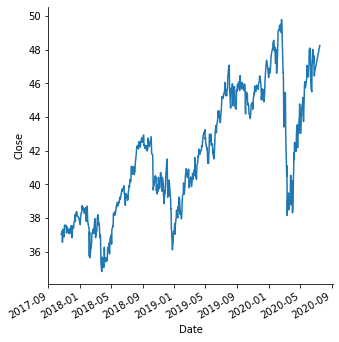

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df).fig.autofmt_xdate()

# preprocessing

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
le = preprocessing.LabelEncoder()

In [11]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [12]:
days_cutoff = len(df) - days_to_forecast

In [13]:
scaled_Close = scaler.fit_transform(df[['Close']])

In [14]:
scaled_Close = np.squeeze(scaled_Close)

In [15]:
df.values[days_cutoff:, 7]

array([652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
       665, 666, 667, 668, 669, 670, 671], dtype=object)

In [16]:
x_train, y_train = df.values[:days_cutoff, 7], scaled_Close[:days_cutoff]
x_test, y_test = df.values[days_cutoff:, 7], scaled_Close[days_cutoff:]

x_train, y_train = df.values[:600, 0], scaled_Close[:600]
x_test, y_test = df.values[600:, 0], scaled_Close[600:]

In [17]:
x_train.shape, x_test.shape

((652,), (20,))

# split train data

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)


## statsmodels

In [20]:
df.head()

Date       High        Low       Open      Close    Volume  Adj Close  \
0 2017-10-20  37.209999  36.990002  37.200001  37.040001  144269.0  35.829071   
1 2017-10-23  37.220001  37.060001  37.099998  37.119999  166719.0  35.906456   
2 2017-10-24  37.220001  36.930000  36.970001  37.220001  138598.0  36.003181   
3 2017-10-25  37.189999  36.540001  37.160000  36.570000  243960.0  35.374439   
4 2017-10-26  37.040001  36.700001  36.770000  36.970001  266729.0  35.761356   

   Date encoded  
0             0  
1             1  
2             2  
3             3  
4             4

In [21]:
data = df.set_index('Date')

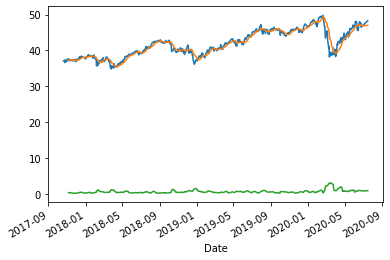

In [22]:
data.Close.plot()
data.Close.rolling(12).mean().plot(label= '12 month rolling mean')
data.Close.rolling(12).std().plot(label='12 month rolling std')

In [23]:
#import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.graph_objects as go

In [24]:
decomposition = seasonal_decompose(data.Close, model='multiplicative', period=100)

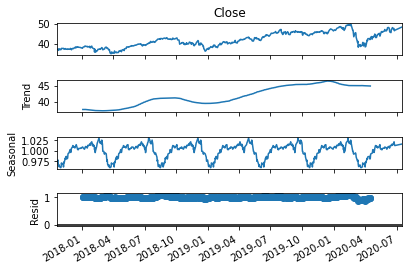

In [25]:
decomposition.plot().autofmt_xdate()

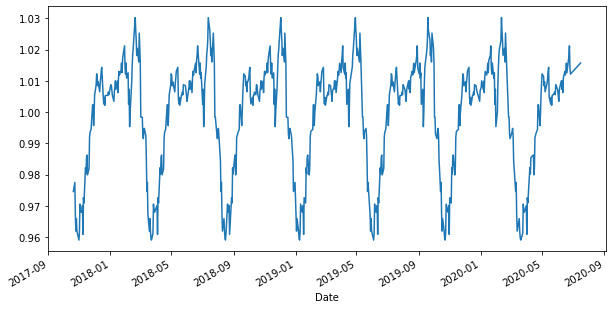

In [26]:
plt.figure(figsize=(10, 5))
decomposition.seasonal.plot()
#plt.plot(decomposition.seasonal)

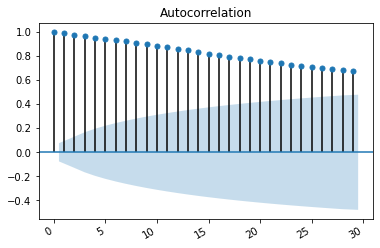

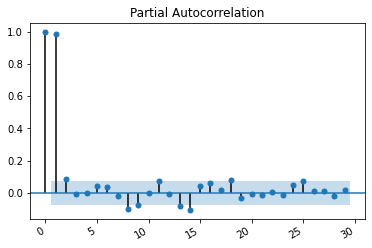

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.Close).autofmt_xdate()
plot_pacf(data.Close).autofmt_xdate()